In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/github/data-science/new_project

/content/drive/MyDrive/github/data-science/new_project


In [ ]:
%ls

 Balanced_I_hotel_dataset_final.ipynb     LSTM_stop_final_lstm_ablation.ipynb
 Balanced_II_hotel_dataset_final.ipynb    optuna_test/
 booking_time_final_original/             output/
 Business_hotel_dataset_final.ipynb       output_other_dataset/
 clustered_test.pkl                       Preprocess_data_dunnhumby.ipynb
 copy_optuna_test/                        Preprocess_data_full_hotel_dataset_final.ipynb
 data_analysis/                           price_tft/
 Leisure_hotel_dataset_final.ipynb        RandomForestRegressor_final_dunnhumby.ipynb
 lightning_logs/                          RandomForestRegressor_final.ipynb
 LSTM_final_dunnhumby_FINAL.ipynb        'Readme file.gdoc'
 LSTM_next_final_ablation.ipynb           TFT_creation_to_creation_final.ipynb
 LSTM_next_final.ipynb                    tft.pkl
 LSTM_next_final_no_lstm_ablation.ipynb   TFT_target_price_final.ipynb
 LSTM_stop_final_ablation.ipynb           Trained_models/
 LSTM_stop_final.ipynb                    Transformer_enc

imported libraries

In [ ]:
!pip install pytorch_forecasting
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_ext

In [ ]:

import os
import pandas as pd
from datetime import date, timedelta, datetime
import numpy as np
import lightning.pytorch as pl
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.data.encoders import NaNLabelEncoder

from sklearn.ensemble import RandomForestRegressor
import math
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.cluster import DBSCAN

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns

To ignore warnings:


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_all_hotels_remv = pd.read_feather('output/10_selected_guest_data/df_all_hotels_remv_updated_withminus1000_dif_clus')

In [ ]:
dates = pd.date_range(start=df_all_hotels_remv["creation_date"].dt.date.min(), end= df_all_hotels_remv["creation_date"].dt.date.max())
lst_values = list(range(1, len(dates) + 1))
dict_dates = {dates[i]: lst_values[i] for i in range(len(dates))}

In [ ]:
df_all_hotels_remv["time_index_with_creation_date"] = df_all_hotels_remv["creation_date"].dt.date.map(dict_dates)

In [ ]:
df_all_hotels_remv = df_all_hotels_remv[df_all_hotels_remv["creation_to_new_creation"] != -1000]

In [ ]:
all_guest_ids = df_all_hotels_remv['guest_id'].unique()
np.random.seed(42)
all_idxs = np.arange(len(all_guest_ids))
np.random.shuffle(all_idxs)
train_idxs, valid_idxs = all_idxs[:int(0.8*len(all_guest_ids))], all_idxs[int(0.8*len(all_guest_ids)):]
train_guest_ids, valid_guest_ids = all_guest_ids[train_idxs], all_guest_ids[valid_idxs]

df_train = df_all_hotels_remv[df_all_hotels_remv['guest_id'].isin(train_guest_ids)]
df_valid = df_all_hotels_remv[df_all_hotels_remv['guest_id'].isin(valid_guest_ids)]

In [ ]:
df_all_hotels_remv["creation_to_new_creation"].describe()

count    101049.000000
mean        319.089739
std         249.833952
min           1.000000
25%         117.000000
50%         295.000000
75%         411.000000
max        1094.000000
Name: creation_to_new_creation, dtype: float64

Time series dataset

In [ ]:

max_prediction_length = 1
max_encoder_length = 418
training_cutoff = df_all_hotels_remv["time_index"].max() - max_prediction_length

training = TimeSeriesDataSet(
    df_train,
    time_idx="time_index",
    target="creation_to_new_creation",
    group_ids=["guest_id"],
    # min_encoder_length = 1,
    min_encoder_length= 1, #max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    # static_categoricals=["guest_id"],  #TODO: Is this needed?
    # static_reals=["birthday"],# embeddings e.g.
    # time_varying_known_categoricals=["month_number", "week_number"], #This part is either belong to this variable or variable time_varying_known_reals
    # variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    # time_varying_known_reals=['time_index'],#, "time_index_with_creation_date"],#, 'month_number', 'week_number'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals= ['nights', 'adults', 'lodging', 'beauty', 'extras', 'price', 'rooms',
       'kids', 'labels','vacation_creation_date', 'holiday_creation_date', 'vacation_arrival_date', 'holiday_arrival_date',
        'weekend_arrival_date', 'weekend_creation_date', "time_index_with_creation_date"
    ],
    # target_normalizer=GroupNormalizer(
        # groups=["state"], transformation="softplus"
    # ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=False,
    add_encoder_length=True,
    allow_missing_timesteps=False,
    categorical_encoders = {'guest_id': NaNLabelEncoder(add_nan=True)}
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, df_valid, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 256  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=20,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [ ]:

import pickle
# torch.set_float32_matmul_precision('medium' | 'high')
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="booking_time_final_original",
    n_trials=5,
    max_epochs=20,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.01, 0.3),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("clustered_test.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2023-10-19 12:18:23,241] A new study created in memory with name: no-name-79830065-15cd-4e57-bd4d-e8d10053cde5
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
[I 2023-10-19 12:22:58,738] Trial 0 finished with value: 310.89483642578125 and parameters: {'gradient_clip_val': 0.02689865024774806, 'hidden_size': 8, 'dropout': 0.2832688866131458, 'hidden_continuous_size': 8, 'attention_head_size': 4, 'learning_rate': 0.011011016846278351}. Best is trial 0 with value: 310.89483642578125.
INFO:pytorch_

{'gradient_clip_val': 0.891749301051541, 'hidden_size': 23, 'dropout': 0.289872724143362, 'hidden_continuous_size': 11, 'attention_head_size': 3, 'learning_rate': 0.08172382678842981}


Get the best performing TFT model

In [ ]:
best_tft = TemporalFusionTransformer.load_from_checkpoint("booking_time_final_original/trial_4/epoch=19-v1.ckpt")
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Evaluation metrics

In [ ]:
labels_list = []
for label in raw_predictions.x["decoder_target"]:
  labels_list.append(label[0].item())

In [ ]:
prediction_list = []
for prediction in raw_predictions.output[0]:
  prediction_list.append(prediction[0][3].item())

In [ ]:
mse = mean_squared_error(labels_list, prediction_list)
np.sqrt(mse)

228.83492186180786

In [ ]:
mae = mean_absolute_error(labels_list, prediction_list)
print(mae)

166.7188087532045


(0.0, 0.005)

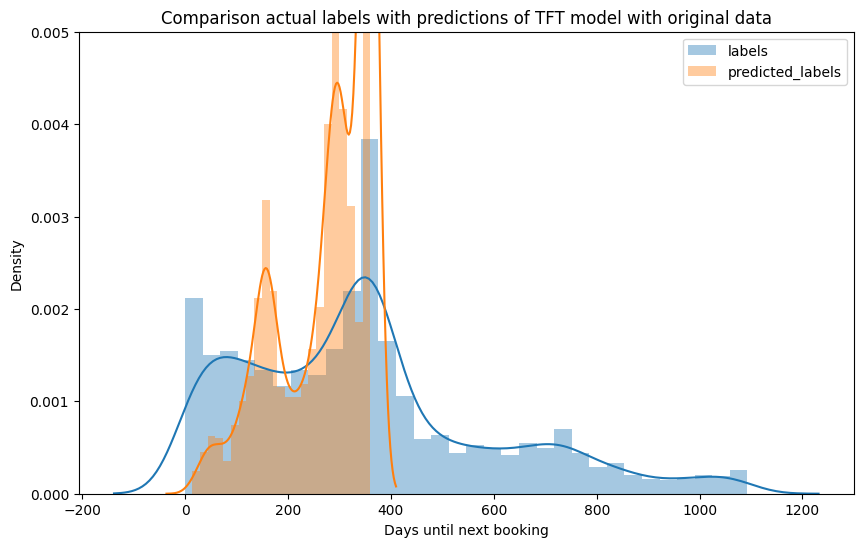

In [ ]:

fig = plt.figure(figsize=(10,6))
sns.distplot(labels_list,hist = True, label ="labels")
sns.distplot(prediction_list,hist = True, label ="predicted_labels")
plt.title("Comparison actual labels with predictions of TFT model with original data")
plt.xlabel("Days until next booking")
plt.legend()
plt.ylim((0, 0.005))

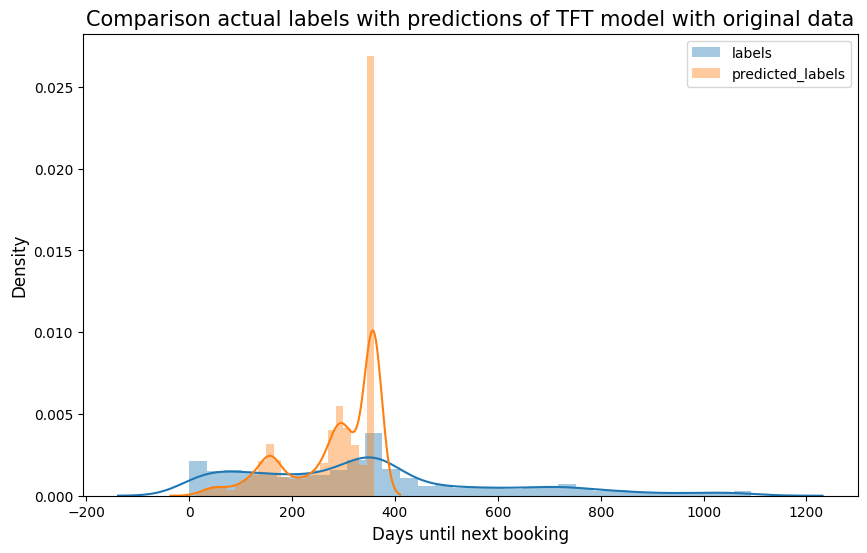

In [ ]:

fig = plt.figure(figsize=(10,6))
sns.distplot(labels_list,hist = True, label ="labels")
sns.distplot(prediction_list,hist = True, label ="predicted_labels")
plt.title("Comparison actual labels with predictions of TFT model with original data", size = 15)
plt.xlabel("Days until next booking", size = 12)
plt.ylabel("Density", size = 12)
plt.legend()

In [ ]:
df = pd.DataFrame(list(zip(labels_list, prediction_list)))
df.columns

RangeIndex(start=0, stop=2, step=1)

Text(0, 0.5, 'Density')

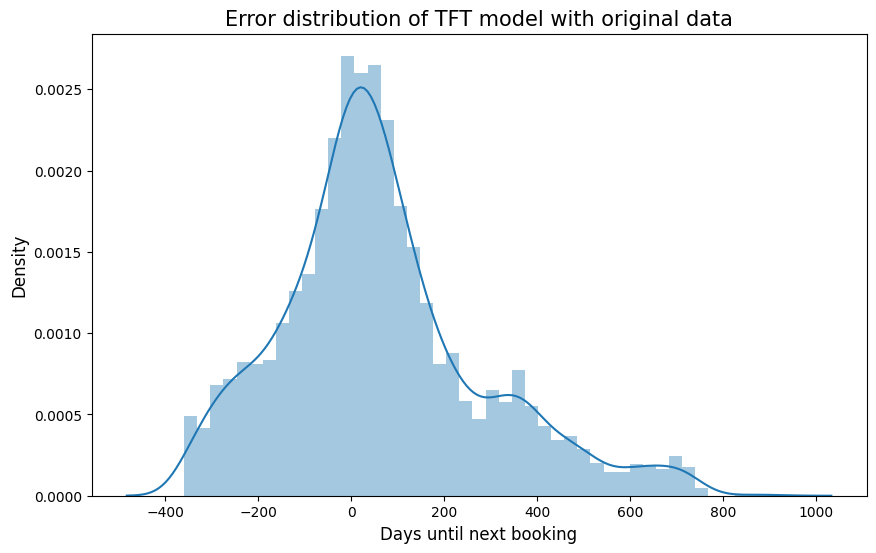

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.distplot(df[0] - df[1],hist = True)
plt.title("Error distribution of TFT model with original data", size = 15)
plt.xlabel("Days until next booking", size = 12)
plt.ylabel("Density", size = 12)

In [ ]:
df = pd.concat([pd.Series(labels_list), pd.Series(prediction_list)], axis = 1)
df.columns = ["labels", "next_event"]

In [ ]:
df["labels_label"] = 0
df["next_event_label"] = 0
for i in range(len(df)):
  if df["labels"][i] < 117:
    df["labels_label"][i] = 1
  elif 117 < df["labels"][i] < 295:
    df["labels_label"][i] = 2
  elif 295 < df["labels"][i] < 411:
    df["labels_label"][i] = 3
  else:
    df["labels_label"][i] = 4
  if df["next_event"][i] < 117:
    df["next_event_label"][i] = 1
  elif 117 < df["next_event"][i] < 295:
    df["next_event_label"][i] = 2
  elif 295 < df["next_event"][i] < 411:
    df["next_event_label"][i] = 3
  else:
    df["next_event_label"][i] = 4

In [ ]:
precision_score(df["labels_label"], df["next_event_label"], average = "macro")

0.3174950051048163

In [ ]:
recall_score(df["labels_label"], df["next_event_label"], average = "macro")

0.3215234378852706

In [ ]:
f1_score(df["labels_label"], df["next_event_label"], average = "macro")

0.2697820324006857

In [ ]:

cm = confusion_matrix(df["labels_label"], df["next_event_label"])
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cmn, index = [1, 2, 3, 4], columns = [1,2,3,4])

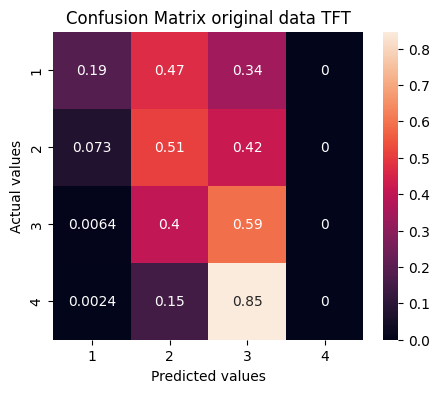

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot = True)
plt.title("Confusion Matrix original data TFT")
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
plt.show()

Interpretation of the variables

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x225 with 1 Axes>,
 'encoder_variables': <Figure size 700x625 with 1 Axes>,
 'decoder_variables': <Figure size 700x225 with 1 Axes>}

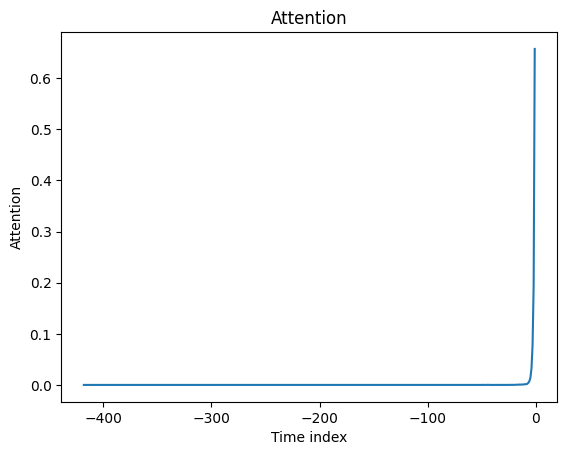

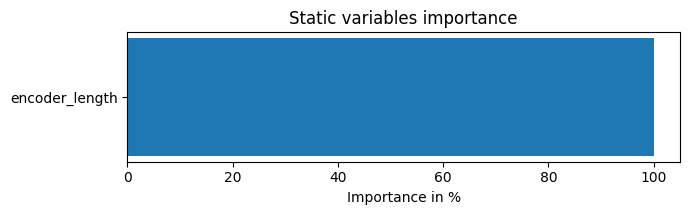

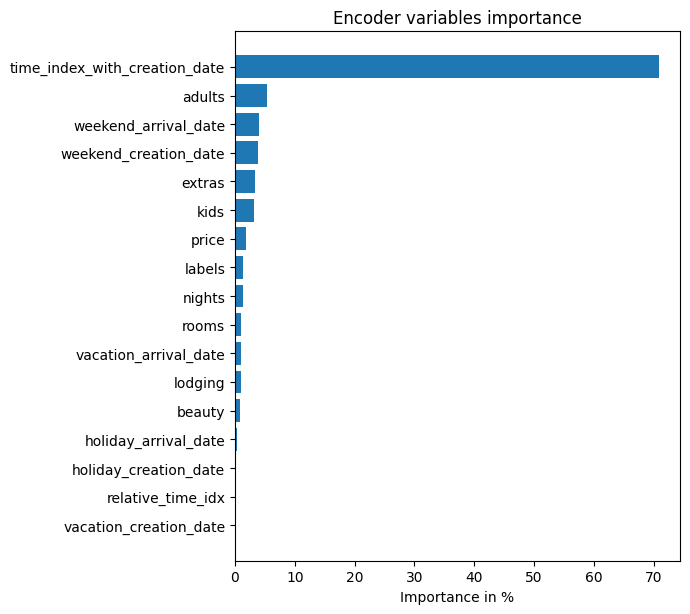

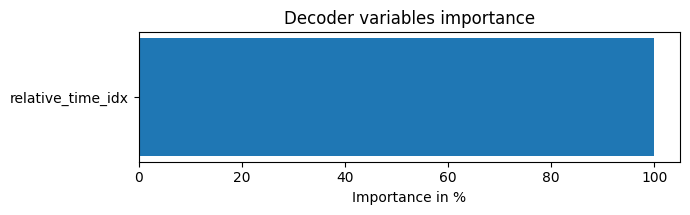

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)